# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [32]:
# Install the required libraries
!pip install prophet

In [33]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [34]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

C:\Users\jesseparent\AppData\Local\Temp\ipykernel_11632\1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [35]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Figure size 640x480 with 0 Axes>

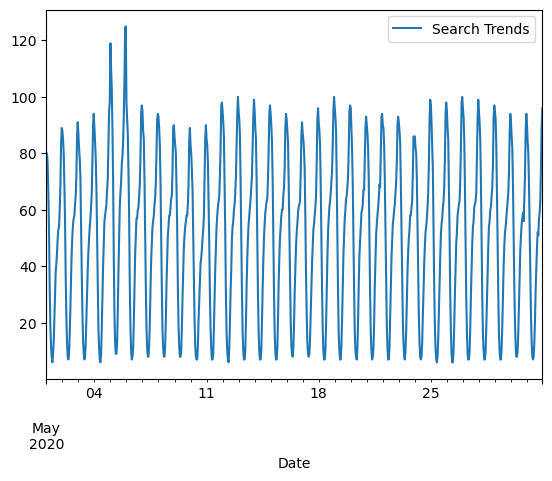

In [36]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']


# Plot to visualize the data for May 2020
plt.clf()
df_may_2020.plot()
plt.show()



<Figure size 640x480 with 0 Axes>

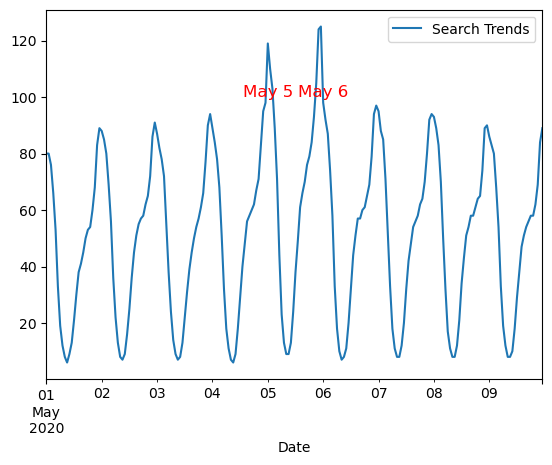

In [37]:
# Zoom in on thr beginning of the month to identify the days of the two peaks

plt.clf()
df_may_2020['2020-05-01':'2020-05-09'].plot()
# Identify the peaks on May 5 and May 6 and label them in red text
plt.text('2020-05-05', 100, 'May 5', fontsize=12, ha='center', color='red')
plt.text('2020-05-06', 100, 'May 6', fontsize=12, ha='center', color='red')
plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [38]:
# SAMPLE OUTPUT
# Search Trends    38181
# dtype: int64

# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020.sum()

# View the traffic_may_2020 value
print(traffic_may_2020)


Search Trends    38181
dtype: int64


In [39]:
# SAMPLE OUTPUT
# Search Trends    35172.5
# dtype: float64

# Calculate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
print(median_monthly_traffic)


Search Trends    35172.5
dtype: float64


In [40]:
# Compare the search traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes - There seemed to be slightly above average traffic in May 2020. We can clearly see from the graphs that there were abnormal peaks in traffic on May 5 and 6, specifically.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

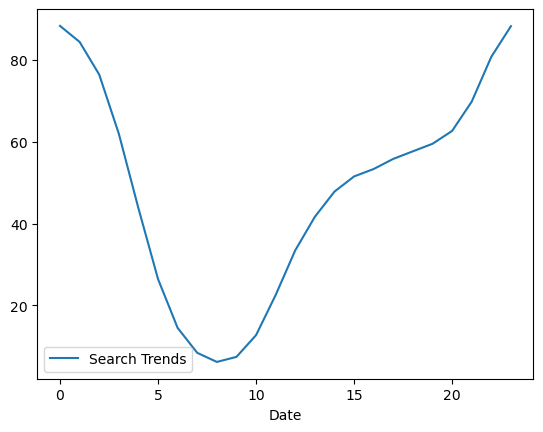

In [41]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`

plt.clf()
hourly_trends = df_mercado_trends["Search Trends"].groupby(df_mercado_trends.index.hour).mean()
hourly_trends.plot()
plt.legend(['Search Trends'])
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

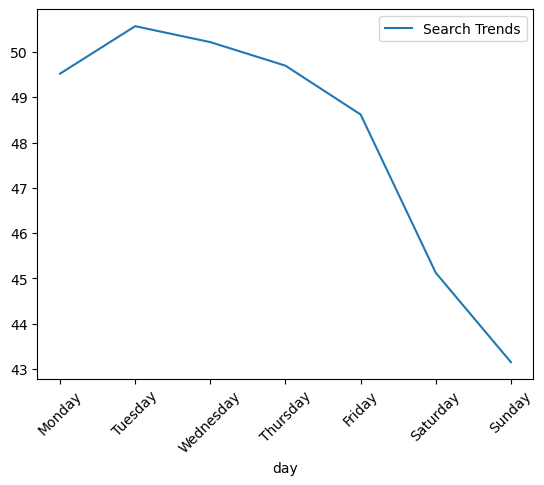

In [42]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
plt.clf()
dayofweek_trends = df_mercado_trends["Search Trends"].groupby(df_mercado_trends.index.isocalendar().day).mean()

# Map numerical days to their string names
days_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayofweek_trends.index = [days_labels[day - 1] for day in dayofweek_trends.index]

dayofweek_trends.plot()

plt.legend(['Search Trends'])
plt.xlabel('day')
plt.xticks(rotation=45)
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

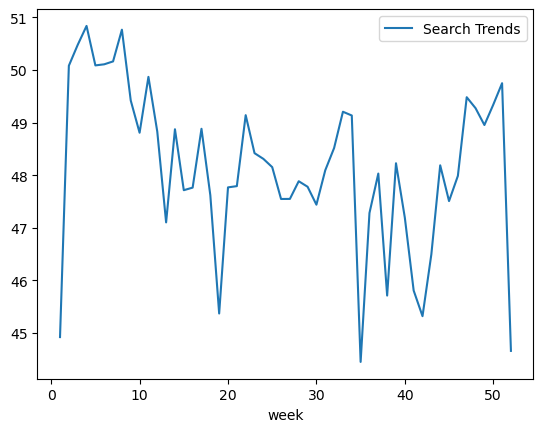

In [43]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
plt.clf()
weekofyear_trends = df_mercado_trends["Search Trends"].groupby(df_mercado_trends.index.isocalendar().week).mean()
weekofyear_trends.plot()
plt.legend(['Search Trends'])
plt.xlabel('week')
plt.show()



##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Yes. in the hourly data we can see that traffic trends up in the later hours and down towards midday hours. We also see in the day of week trends that traffic trends high in the beginning of the week and tapers off by the weekend. For weeks of the year, we see higher traffic towards the last few weeks of the year, plummeting at the last week of the year that continues to be low in the first week of the next year and then rises into the beginning of the year, tapering off by week 6. This follows holiday patterns around Christmas and New Years.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [44]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


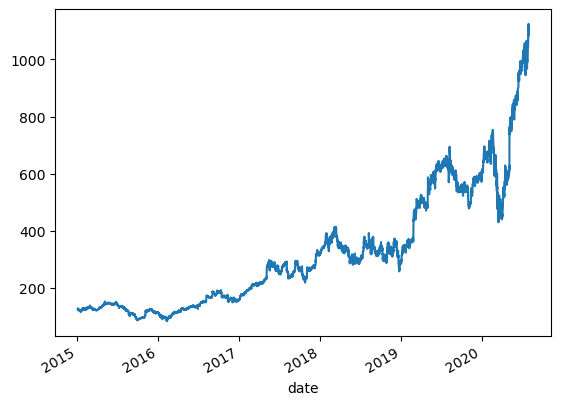

In [45]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.clf()
df_mercado_stock['close'].plot()
plt.show()

In [46]:
# SAMPLE OUTPUT
# close	Search Trends
# 2016-06-01 09:00:00	135.16	6.0
# 2016-06-01 10:00:00	136.63	12.0
# 2016-06-01 11:00:00	136.56	22.0
# 2016-06-01 12:00:00	136.42	33.0
# 2016-06-01 13:00:00	136.10	40.0
# close	Search Trends
# 2020-07-31 11:00:00	1105.780	20.0
# 2020-07-31 12:00:00	1087.925	32.0
# 2020-07-31 13:00:00	1095.800	41.0
# 2020-07-31 14:00:00	1110.650	47.0
# 2020-07-31 15:00:00	1122.510	53.0

# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop any rows with only one column of data
mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [47]:
# SAMPLE OUTPUT
# close	Search Trends
# 2020-01-02 09:00:00	601.085	9.0
# 2020-01-02 10:00:00	601.290	14.0
# 2020-01-02 11:00:00	615.410	25.0
# 2020-01-02 12:00:00	611.400	37.0
# 2020-01-02 13:00:00	611.830	50.0
# close	Search Trends
# 2020-06-30 11:00:00	976.17	17.0
# 2020-06-30 12:00:00	977.50	27.0
# 2020-06-30 13:00:00	973.23	37.0
# 2020-06-30 14:00:00	976.50	45.0
# 2020-06-30 15:00:00	984.93	51.0

# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = mercado_stock_trends_df.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


<Figure size 640x480 with 0 Axes>

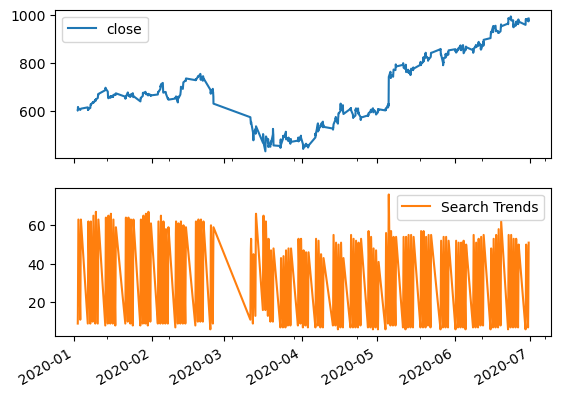

In [48]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
plt.clf()
first_half_2020.plot(subplots=True)
plt.show()



##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** The closing price trend supports the narrative of recovery and growth for e-commerce platforms in the first half of 2020 after the initial shock in March. The search trends, however, do not show a clear trend that aligns with the narrative. Their high volatility suggests that consumer interest may have fluctuated rather than steadily increased, making them less reliable as an indicator of recovery. There is a clear event in the beginning of may that not only created a spike in search trends, but also an increase in stock price, which matches previous analysis above around the timing of the release of Mercado's financial results.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [49]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)

mercado_stock_trends_df.head()



,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


In [50]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(4).std()

mercado_stock_trends_df.head()


,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134


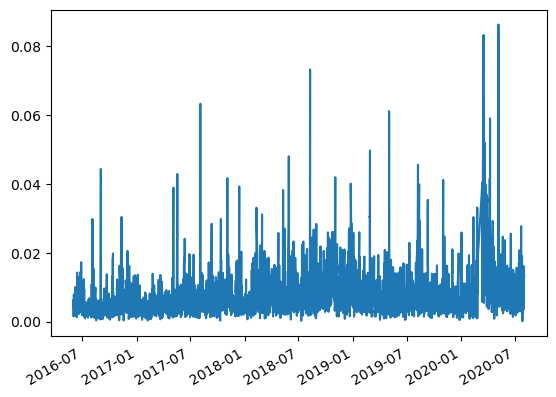

In [51]:
# Visualize the stock volatility
plt.clf()
mercado_stock_trends_df['Stock Volatility'].plot()
plt.show()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [52]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()

In [53]:
# SAMPLE OUTPUT
# close	Search Trends	Lagged Search Trends	Stock Volatility	Hourly Stock Return
# 2016-06-01 09:00:00	135.16	6.0	NaN	NaN	NaN
# 2016-06-01 10:00:00	136.63	12.0	6.0	NaN	0.010876
# 2016-06-01 11:00:00	136.56	22.0	12.0	NaN	-0.000512
# 2016-06-01 12:00:00	136.42	33.0	22.0	NaN	-0.001025
# 2016-06-01 13:00:00	136.10	40.0	33.0	0.006134	-0.002346
# close	Search Trends	Lagged Search Trends	Stock Volatility	Hourly Stock Return
# 2020-07-31 11:00:00	1105.780	20.0	11.0	0.012837	0.006380
# 2020-07-31 12:00:00	1087.925	32.0	20.0	0.013549	-0.016147
# 2020-07-31 13:00:00	1095.800	41.0	32.0	0.013295	0.007239
# 2020-07-31 14:00:00	1110.650	47.0	41.0	0.013001	0.013552
# 2020-07-31 15:00:00	1122.510	53.0	47.0	0.013566	0.010678

# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [54]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** No strong or predictable relationship exists between lagged search traffic and either stock volatility or stock returns. All the correlations are weak (absolute values near 0), implying that none of these variables are closely or consistently linked in this dataset.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [55]:
# SAMPLE OUTPUT
# ds	y
# 0	2016-06-01 00:00:00	97
# 1	2016-06-01 01:00:00	92
# 2	2016-06-01 02:00:00	76
# 3	2016-06-01 03:00:00	60
# 4	2016-06-01 04:00:00	38
# ds	y
# 37101	2020-09-07 20:00:00	71
# 37102	2020-09-07 21:00:00	83
# 37103	2020-09-07 22:00:00	96
# 37104	2020-09-07 23:00:00	97
# 37105	2020-09-08 00:00:00	96

# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
# Reset the index using the reset_index function
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds', 'y']

# Drop any NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()  

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [57]:
# Call the Prophet function, store as an object
model_mercado = Prophet()
model_mercado

In [58]:
# Fit the time-series model.
model_mercado.fit(mercado_prophet_df)


17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
# SAMPLE OUTPUT	
# 	ds
# 39101	2020-11-30 04:00:00
# 39102	2020-11-30 05:00:00
# 39103	2020-11-30 06:00:00
# 39104	2020-11-30 07:00:00
# 39105	2020-11-30 08:00:00

# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_df = model_mercado.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_df.tail())


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [61]:
# SAMPLE OUTPUT
# ds	trend	yhat_lower	yhat_upper	trend_lower	trend_upper	additive_terms	additive_terms_lower	additive_terms_upper	daily	...	weekly	weekly_lower	weekly_upper	yearly	yearly_lower	yearly_upper	multiplicative_terms	multiplicative_terms_lower	multiplicative_terms_upper	yhat
# 0	2016-06-01 00:00:00	44.469500	80.657755	98.092527	44.469500	44.469500	45.159722	45.159722	45.159722	41.452703	...	1.860594	1.860594	1.860594	1.846426	1.846426	1.846426	0.0	0.0	0.0	89.629222
# 1	2016-06-01 01:00:00	44.470406	77.585016	94.403906	44.470406	44.470406	41.605529	41.605529	41.605529	37.943556	...	1.810498	1.810498	1.810498	1.851474	1.851474	1.851474	0.0	0.0	0.0	86.075935
# 2	2016-06-01 02:00:00	44.471312	67.254855	83.562064	44.471312	44.471312	31.282049	31.282049	31.282049	27.656646	...	1.768912	1.768912	1.768912	1.856491	1.856491	1.856491	0.0	0.0	0.0	75.753361
# 3	2016-06-01 03:00:00	44.472218	52.594834	69.279039	44.472218	44.472218	16.014826	16.014826	16.014826	12.417424	...	1.735926	1.735926	1.735926	1.861476	1.861476	1.861476	0.0	0.0	0.0	60.487045
# 4	2016-06-01 04:00:00	44.473124	34.860822	51.829818	44.473124	44.473124	-1.100073	-1.100073	-1.100073	-4.677999	...	1.711496	1.711496	1.711496	1.866430	1.866430	1.866430	0.0	0.0	0.0	43.373051
# 5 rows × 22 columns

# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model_mercado.predict(future_mercado_df)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.352625,81.775458,98.122089,44.352625,44.352625,45.307367,45.307367,45.307367,41.452720,...,1.860390,1.860390,1.860390,1.994257,1.994257,1.994257,0.0,0.0,0.0,89.659992
1,2016-06-01 01:00:00,44.353557,78.106701,95.431731,44.353557,44.353557,41.753097,41.753097,41.753097,37.943514,...,1.810288,1.810288,1.810288,1.999294,1.999294,1.999294,0.0,0.0,0.0,86.106654
2,2016-06-01 02:00:00,44.354489,66.969033,83.915996,44.354489,44.354489,31.429548,31.429548,31.429548,27.656552,...,1.768695,1.768695,1.768695,2.004301,2.004301,2.004301,0.0,0.0,0.0,75.784037
3,2016-06-01 03:00:00,44.355421,52.149104,69.027127,44.355421,44.355421,16.162280,16.162280,16.162280,12.417302,...,1.735704,1.735704,1.735704,2.009275,2.009275,2.009275,0.0,0.0,0.0,60.517701
4,2016-06-01 04:00:00,44.356353,34.544154,51.984116,44.356353,44.356353,-0.952639,-0.952639,-0.952639,-4.678127,...,1.711270,1.711270,1.711270,2.014218,2.014218,2.014218,0.0,0.0,0.0,43.403713


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

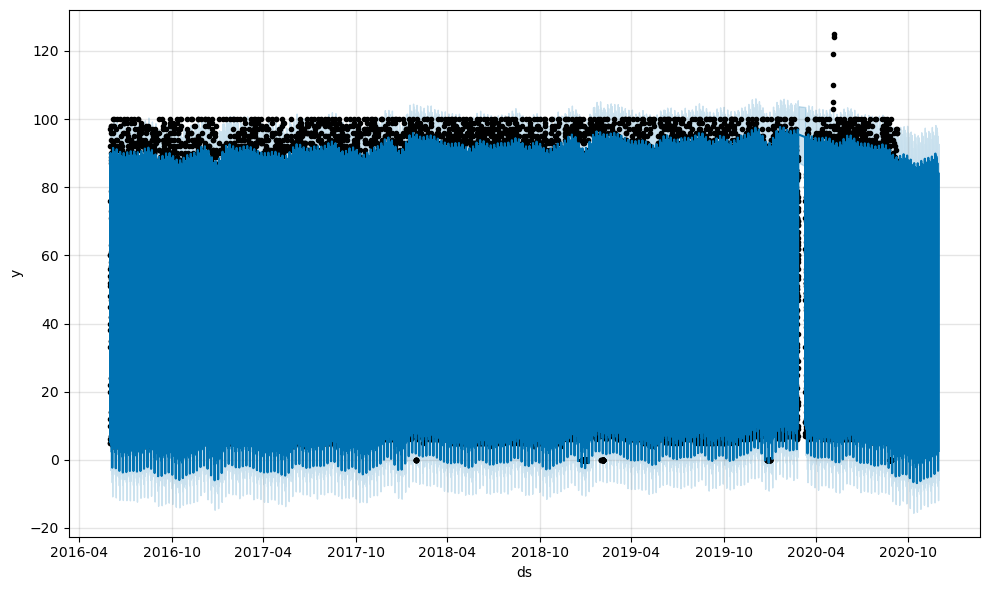

In [62]:
# Plot the Prophet predictions for the Mercado trends data
model_mercado.plot(forecast_mercado_trends)


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** There is a distinct drop in popularity being forecast in the near term for search trends on Mercado. It will start to rise again but we don't have enough time allotted in our future predictions to estimate if it will return to its former popularity.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [63]:
# SAMPLE OUTPUT
# yhat	yhat_lower	yhat_upper
# ds			
# 2016-06-01 00:00:00	89.629222	80.657755	98.092527
# 2016-06-01 01:00:00	86.075935	77.585016	94.403906
# 2016-06-01 02:00:00	75.753361	67.254855	83.562064
# 2016-06-01 03:00:00	60.487045	52.594834	69.279039
# 2016-06-01 04:00:00	43.373051	34.860822	51.829818

# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head()



,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.659992,81.775458,98.122089
2016-06-01 01:00:00,86.106654,78.106701,95.431731
2016-06-01 02:00:00,75.784037,66.969033,83.915996
2016-06-01 03:00:00,60.517701,52.149104,69.027127
2016-06-01 04:00:00,43.403713,34.544154,51.984116


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Figure size 1000x600 with 0 Axes>

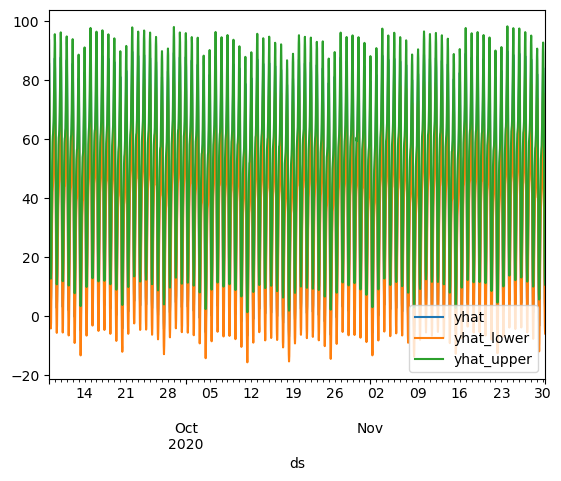

In [64]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
plt.clf()
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:].plot()
plt.show()


<Figure size 640x480 with 0 Axes>

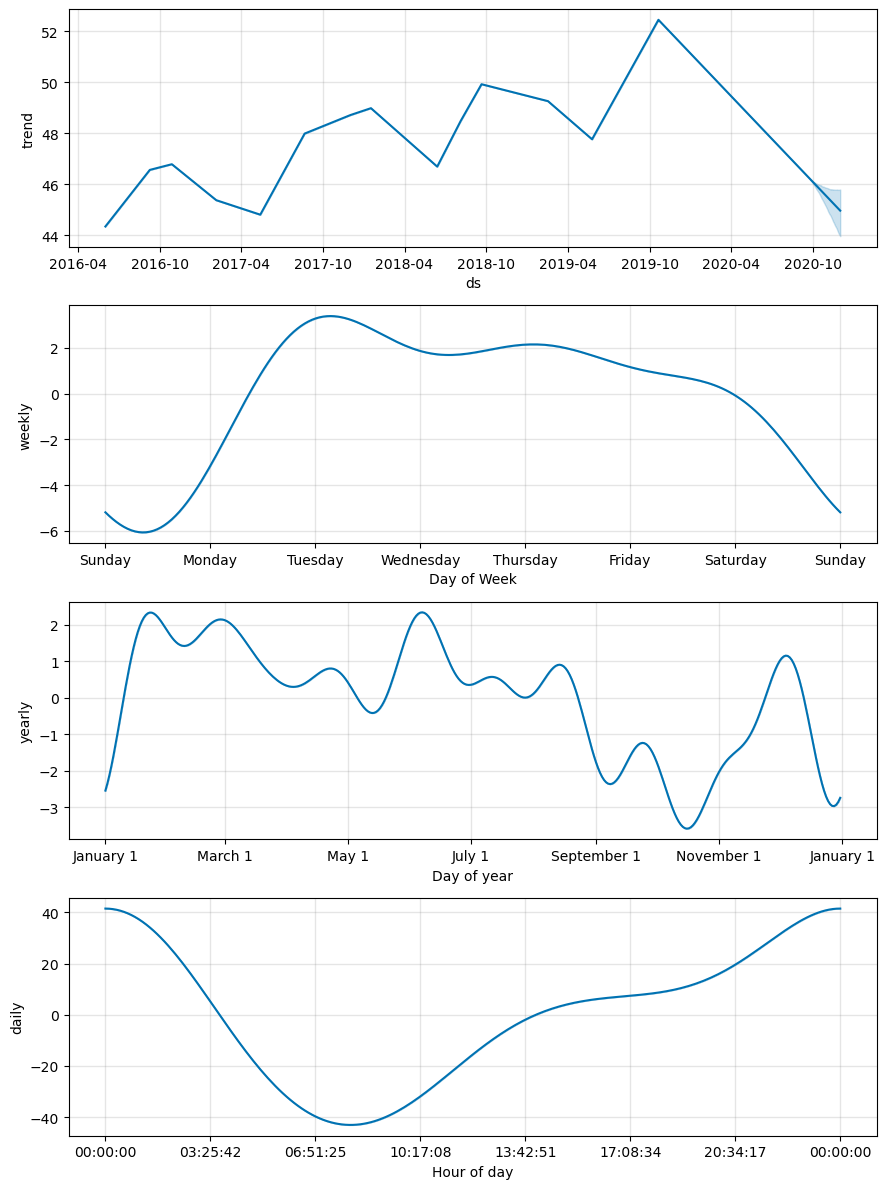

In [65]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
plt.clf()
model_mercado.plot_components(forecast_mercado_trends)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The peak is around midnight, rising steadily from around 8PM. The Lowest is around 7-8AM.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday appears to get the highest amount of traffic followed by Thursday.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Looking at the weekly trend, somewhere around mid-October seems to be a low point in the calendar year.
